# First Workthrough
Writing this notebook involved 100 reordering of all these steps.  Though it runs start-to-finish, it is not the final form for model creation.  This notebook guided the steps used in Notebook 2, where I merge the training and testing data for synchronized cleaning.

The steps for cleaning were determined here with no incorporation of the test set, and thus were protected from data leakage.  When merging with test, the below steps will be in a somewhat different order.

Notes for Helen's future project2 notebooks:
* Drop_first=False when dummifying categories here.  If not, the randomly chosen reference column becomes the basis of all your scoring/correlations, and with so many features that you are dummifying, you're creating a weird many-attributed-hypothetical-reference property...
    * Your first attempted linear models yielded an average predicted value of 3.6M, so something was very wrong.  Might have been the drop_first=True.
* Maybe don't log transform the discrete numerical columns?  Try without first, then see if log transform improves.

In [1]:
import numpy as np
import pandas as pd
import scipy as stats
from scipy.stats import skew
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.metrics import r2_score

## Citations
Source 1: 'Intermediate Data Cleaning' by Kevin Crystal, GA-DSI alumn
- https://medium.com/@kevin.a.crystal/intermediate-data-cleaning-195e1af3ccf9
- Mostly used for conceptual approach to cleaning.  Noted in code notes if actual code used.


Source 2: 'Comprehensive data exploration with Python' by Pedro Marcelino
- https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
- ripped code to print df of nulls and what % of the column those nulls represent


Source 3: 'A study on Regression applied to the Ames dataset' by Julien Cohen Solal
- https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

Source 4: 'Trying out a linear model' by Alexandru Papiu
- https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models

In [2]:
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

In [3]:
ames = pd.read_csv('./datasets/train.csv')
test_set = pd.read_csv('./datasets/test.csv')

In [4]:
print(ames.shape)
ames.head()

(2051, 81)


,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,GasA,TA,Y,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,Gd,5,Typ,0,NaN,Detchd,1953.0,Unf,1.0,246.0,TA,TA,Y,0,52,0,0,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,SBrkr,744,700,0,1444,0.0,0.0,2,1,3,1,TA,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,PConc,Fa,Gd,No,Unf,0.0,Unf,0.0,676.0,676.0,GasA,TA,Y,SBrkr,831,614,0,1445,0.0,0.0,2,0,3,1,TA,6,Typ,0,NaN,Detchd,1957.0,Unf,2.0,484.0,TA,TA,N,0,59,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [5]:
ames.columns = ames.columns.str.lower().str.replace(" ","_")

In [6]:
#ames.info()

In [7]:
#check for duplicate IDs
ames.shape[0] - len(set(ames.id))

0

In [8]:
#nulls and what % of factor, code from Source 2
nulls= ames.isnull().sum().sort_values(ascending=False)
perc= (ames.isnull().sum()/ames.isnull().count()).sort_values(ascending=False)
missing_data= pd.concat([nulls, perc],axis=1, keys=['# nulls', '% null'])
missing_data

,# nulls,% null
pool_qc,2042,0.995612
misc_feature,1986,0.968308
alley,1911,0.931741
fence,1651,0.804973
fireplace_qu,1000,0.487567
lot_frontage,330,0.160897
garage_finish,114,0.055583
garage_cond,114,0.055583
garage_qual,114,0.055583
garage_yr_blt,114,0.055583


### Uninformative columns
The top four features in the above chart (nulls and % nulls) have over 80% null values.  Given this lack of data, these columns are being considered for removal from analysis.

Secondly, 'Fence' is described as ordinal, but the categories are not well delineated: ie a fence can be good wood (GdWo) and minimum privacy (MnPrv), or other combos.  This confusion may introduce more noise than information.

For cleaning consistency, I will first proceed with cleaning nulls from the whole dataset, but remember that the following four columns are candidates for removal unless compelling correlations come to light. 
- Alley
- Misc Feature
- Pool QC
- Fence

### False Nulls
According to the data dictionary, 'NA' can be used to indicate that a particular property attribute does not exist, amidst an otherwise ordinal list of ranking that attribute.  For instance, 'Rating of basement finished area' is on a scale of Unfinished up to Good Living Quarters, with NA indicating that there is no basement.  In this scenario, NA can = 0, Unfinished = 1, and Good Living Quarters = max.

NA is defined as its own level of ordinal rank (0) in the case of 12 variables.  Many of these share the same 6-level scale (NA, Po, Fa, TA, Gd, Ex).  They also share this scale with other ordinal variables in the dataset that do not contain (or define) NA.  I will convert all of these to a numeric scale together, with Na=0 to Ex=5.  

The Pool variable has all of these levels except for 'Po'; I will still include it in this same scale and just record 0 entries at (Po:1).  Apparently in Ames, any pool is already considered 'Fair', but as a water sport athlete I can tell you there are DEFINITELY 'Poor' pools and Ames county is ignoring a valuable metric.

In [9]:
#cols needing transform from (ordinal) object to numeric
nans_to_zeros = ['bsmt_qual','bsmt_cond', 'fireplace_qu','garage_qual', 'garage_cond',
                 'kitchen_qual', 'exter_qual','exter_cond','heating_qc','garage_finish', 
                 'bsmt_exposure','bsmtfin_type_1','bsmtfin_type_2', 'pool_qc', 'fence']

nans_as_nans = ['lot_shape','utilities','land_slope', 'electrical','functional']

In [10]:
to_num_masterdict={'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5, #nans_to_zeros cols.
'Unf':1, 'RFn':2, 'Fin':3, #garage_finish
'MnWw':1, 'GdWo':2, 'MnPrv':3, 'GdPrv':4, #fence
'No':1, 'Mn':2, 'Av':3, 'Gd':4,#bsmt_exposure
'Unf':1, 'LwQ':2,'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6, #bsmtfin_type_1 and 2
'IR3':1, 'IR2':2, 'IR1':3, 'Reg':4, #lot_shape
'ELO':1, 'NoSeWa':2, 'NoSewr':3, 'Allpub':4, #utilities
'Sev':1, 'Mod':2, 'Gtl':3, #land_slope
'Sal':0, 'Sev':1, 'Maj2':2, 'Maj1':3, 'Mod':4, 'Min2':5, 'Min1':6, 'Typ':7, #functional
'Mix':1, 'FuseP':2, 'FuseF':3, 'FuseA':4, 'SBrkr':5} #electrical

In [11]:
#conversion function
def to_nums_w_zeros(df, targetcols):
    for i in targetcols:
        df[i] = df[i].map(to_num_masterdict)
        df[i] = df[i].fillna(0)
        #print(df[targetcols].value_counts()) #this line to check work, from source1
        

In [12]:
to_nums_w_zeros(ames, nans_to_zeros)

In [13]:
#ames[nans_to_zeros].dtypes  #check that all converted to numeric

In [14]:
#ames.isnull().sum().sort_values(ascending=False).head(16)

### Remaining ordinals to numeric
The remaining 'object' variables that have an ordinal rank do not have NaN's equivalen to 0, so they should be subjected to a numeric transformation that preserves the NaN.  Luckily, none of the remaining features HAVE nulls, so they can be run through the same function without risking misinterpretation.

In [15]:
to_nums_w_zeros(ames, nans_as_nans)

In [16]:
#ames[nans_as_nans].dtypes  #check all numeric

### And the opposite: numerical to object
##### source 3 pointed this step out to me
The MS Subclass column is nominal, but the features have numeric assignments (ie, 020 = '1-story 1946 & newer all styles').  These categories are **not** ordinal: higher number are not necessarily newer nor larger properties.  Thus convert this column to object.

Similarly, Month should be categorized because numeric treatment doesn't make sense like it does for year.

In [17]:
to_obj_masterdict={20:'SC20', 30:'SC30', 40:'SC40', 45:'SC45', 50:'SC50', 60:'SC60',
                 70:'SC70', 75:'SC75', 80:'SC80', 85:'SC85', 90:'SC90', 120:'SC120',
                  150:'SC150', 160:'SC160', 180:'SC180', 190:'SC190', #ms_subclass
                  1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul',
                  8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'} #months

In [18]:
should_be_objs= ['ms_subclass','mo_sold']
def num_to_obj(df, targetcols):
    for i in targetcols:
        df[i] = df[i].map(to_obj_masterdict)

In [19]:
num_to_obj(ames, should_be_objs)

### Removing nulls from nominal vars
Several variables are nominal - so could not fit into the above numerical transformation - but still have NaN's that represent 0.  ie no garage, no alley access, no pool.  Below we will replace these NaN's with 0s.  These NaN's can be replaced with 'None'.

Nominal variables with a NA definition, according to the data dictionary, are:  
- Alley (Grvl, Pave, NA)
- Garage Type (2Types, Attchd, Basment, BuiltIn, CarPort, Detchd, NA)
- Misc Feature (Elev, Gar2, Othr, Shed, TenC, NA)
---
#### Remember:
Alley and Misc Feature initially had over 92% null values.  They are in consideration for dropping altogether.  For now, clean.

In [20]:
def nans2none_nominal(df, targetcols):
    for i in targetcols:
        df[i] = df[i].fillna('None')

In [21]:
nominal_nans = ['alley','misc_feature','garage_type','mas_vnr_type']
nans2none_nominal(ames, nominal_nans)
#mas_vnr_type added to this step after identifying 22 nulls that probably
#should have been classified as 'None'

In [22]:
#check null + %null again
nulls_again=ames.isnull().sum().sort_values(ascending=False)
perc_again= (ames.isnull().sum()/ames.isnull().count()).sort_values(ascending=False)
missing_data2= pd.concat([nulls_again, perc_again],axis=1, keys=['# nulls', '% null'])
missing_data2.head(13)

,# nulls,% null
lot_frontage,330,0.160897
garage_yr_blt,114,0.055583
mas_vnr_area,22,0.010726
bsmt_full_bath,2,0.000975
bsmt_half_bath,2,0.000975
bsmtfin_sf_1,1,0.000488
garage_cars,1,0.000488
garage_area,1,0.000488
bsmtfin_sf_2,1,0.000488
total_bsmt_sf,1,0.000488


In [23]:
ames.loc[ames.garage_yr_blt.isna()].head()

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
28,2243,911103060,SC190,C (all),75.0,8250,Pave,None,4,Lvl,0.0,Inside,3,IDOTRR,Feedr,Norm,2fmCon,2Story,5,6,1895,2006,Gable,CompShg,VinylSd,VinylSd,None,0.0,3,4,CBlock,3.0,3.0,1.0,1.0,0.0,1.0,0.0,957.0,957.0,GasA,2,N,5,1034,957,0,1991,0.0,0.0,2,0,4,2,3,9,7,0,0.0,None,NaN,0.0,0.0,0.0,0.0,0.0,N,0,0,133,0,0,0,0.0,0.0,None,0,Jun,2007,WD,119600
53,330,923226250,SC160,RM,21.0,1476,Pave,None,4,Lvl,0.0,Inside,3,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,3,3,CBlock,3.0,3.0,1.0,6.0,176.0,1.0,0.0,370.0,546.0,GasA,5,Y,5,546,546,0,1092,0.0,0.0,1,1,3,1,3,5,7,0,0.0,None,NaN,0.0,0.0,0.0,0.0,0.0,Y,200,26,0,0,0,0,0.0,0.0,None,0,Mar,2010,WD,76000
65,2278,923202134,SC20,RL,70.0,8402,Pave,None,4,Lvl,0.0,Inside,3,Mitchel,Feedr,Norm,1Fam,1Story,5,5,2007,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,3,3,PConc,4.0,3.0,1.0,5.0,206.0,1.0,0.0,914.0,1120.0,GasA,5,Y,5,1120,0,0,1120,0.0,0.0,1,0,3,1,3,6,7,0,0.0,None,NaN,0.0,0.0,0.0,0.0,0.0,Y,0,30,0,0,0,0,0.0,0.0,None,0,Dec,2007,New,147000
79,2235,910201050,SC50,RM,50.0,7288,Pave,None,4,Lvl,0.0,Inside,3,IDOTRR,Artery,Norm,1Fam,1.5Fin,5,7,1925,2003,Gable,CompShg,VinylSd,VinylSd,None,0.0,4,4,BrkTil,3.0,1.0,1.0,1.0,0.0,1.0,0.0,936.0,936.0,GasA,5,Y,5,936,665,0,1601,0.0,0.0,2,0,3,1,3,6,7,0,0.0,None,NaN,0.0,0.0,0.0,0.0,0.0,N,0,0,0,176,0,0,0.0,0.0,None,0,Sep,2007,WD,129850
101,2084,905476170,SC30,RL,58.0,9098,Pave,None,3,Lvl,0.0,Inside,3,Edwards,Norm,Norm,1Fam,1Story,4,7,1920,2002,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,3,3,BrkTil,3.0,3.0,2.0,5.0,348.0,1.0,0.0,180.0,528.0,GasA,5,Y,5,605,0,0,605,1.0,0.0,1,0,2,1,3,5,7,0,0.0,None,NaN,0.0,0.0,0.0,0.0,0.0,N,0,0,144,0,0,0,0.0,0.0,None,0,Jul,2007,WD,86000


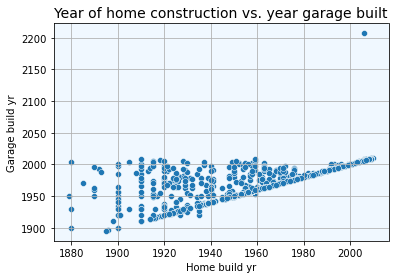

In [24]:
ax=plt.axes()
sns.scatterplot(x='year_built',y='garage_yr_blt',data=ames);
plt.xlabel('Home build yr')
plt.ylabel('Garage build yr')
plt.grid()
ax.set_facecolor("aliceblue");
plt.title('Year of home construction vs. year garage built', size=14);

In [25]:
ames.loc[ames['garage_yr_blt']==ames['garage_yr_blt'].max()]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
1699,2261,916384070,SC20,RL,68.0,8298,Pave,None,3,HLS,0.0,Inside,3,Timber,Norm,Norm,1Fam,1Story,8,5,2006,2007,Hip,CompShg,VinylSd,VinylSd,None,NaN,4,3,PConc,4.0,3.0,3.0,6.0,583.0,1.0,0.0,963.0,1546.0,GasA,5,Y,5,1564,0,0,1564,0.0,0.0,2,0,2,1,5,6,7,1,4.0,Attchd,2207.0,2.0,2.0,502.0,3.0,3.0,Y,132,0,0,0,0,0,0.0,0.0,None,0,Sep,2007,New,267300


Looking at the NaNs in 'Garage Yr Built' shows that they all line up with properties with no garage.  0 is a tricky input as it will skew central tendency.  

Based on the scatterplot of year-of-home-build vs year-of-garage-build it would be logical enough to fill this value with the year of home build.  However this scatter also brings to light a typo (garage built in year 2207, and the more attention I give this variable the more I realize it is trivial. There are six other variables relating to garages, the most important of which will be car capacity, area, and quality.

Any information about garages will be preserved in the other columns about garages.

Drop 'Garage Yr Built' from dataframe.  (All drops after transformation and corr review)

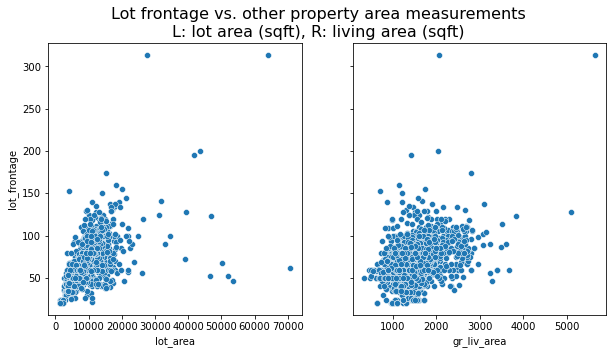

In [26]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5), sharey=True)
sns.scatterplot(x='lot_area',y='lot_frontage',data=ames, ax=ax1)
sns.scatterplot(x='gr_liv_area', y='lot_frontage', data=ames, ax=ax2)
plt.suptitle('Lot frontage vs. other property area measurements\nL: lot area (sqft), R: living area (sqft)', size=16);

Lot frontage is not obviously collinear with another attribute, like the garageX's.  The above scatters show a general positive correlation, but we can't easily derive lot frontage from other property 'area' metrics.  There are too many nulls to justify replacing with a Central Tendency value.  For an arguably low-priority feature when it comes to home-buying, it is safer (and easier) to remove from consideration.

Drop 'Lot Frontage' from dataframe. (All drops after transformation and corr review)

In [27]:
ames.loc[ames['mas_vnr_area'].isna()].head()

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
22,2393,528142010,SC60,RL,103.0,12867,Pave,None,3,Lvl,0.0,Corner,3,NridgHt,Norm,Norm,1Fam,2Story,8,5,2005,2006,Gable,CompShg,CemntBd,CmentBd,None,NaN,4,3,PConc,5.0,3.0,3.0,1.0,0.0,1.0,0.0,1209.0,1209.0,GasA,5,Y,5,1209,1044,0,2253,0.0,0.0,2,1,3,1,5,8,7,1,4.0,Attchd,2005.0,3.0,2.0,575.0,3.0,3.0,Y,243,142,0,0,0,0,0.0,0.0,None,0,Jul,2006,New,344133
41,2383,528110050,SC20,RL,107.0,13891,Pave,None,4,Lvl,0.0,Inside,3,NridgHt,Norm,Norm,1Fam,1Story,10,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,None,NaN,5,3,PConc,5.0,4.0,4.0,6.0,1386.0,1.0,0.0,690.0,2076.0,GasA,5,Y,5,2076,0,0,2076,1.0,0.0,2,1,2,1,5,7,7,1,4.0,Attchd,2006.0,3.0,3.0,850.0,3.0,3.0,Y,216,229,0,0,0,0,0.0,0.0,None,0,Sep,2006,New,465000
86,539,531371050,SC20,RL,67.0,10083,Pave,None,4,Lvl,0.0,Inside,3,SawyerW,Norm,Norm,1Fam,1Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,None,NaN,4,3,PConc,4.0,3.0,1.0,6.0,833.0,1.0,0.0,343.0,1176.0,GasA,5,Y,5,1200,0,0,1200,1.0,0.0,2,0,2,1,4,5,7,0,0.0,Attchd,2003.0,2.0,2.0,555.0,3.0,3.0,Y,0,41,0,0,0,0,0.0,0.0,None,0,Aug,2009,WD,184900
212,518,528458020,SC20,FV,90.0,7993,Pave,None,3,Lvl,0.0,Inside,3,Somerst,Norm,Norm,1Fam,1Story,7,5,2008,2009,Gable,CompShg,VinylSd,VinylSd,None,NaN,4,3,PConc,5.0,3.0,1.0,1.0,0.0,1.0,0.0,1436.0,1436.0,GasA,5,Y,5,1436,0,0,1436,0.0,0.0,2,0,3,1,4,6,7,0,0.0,Attchd,2008.0,3.0,2.0,529.0,3.0,3.0,Y,0,121,0,0,0,0,0.0,0.0,None,0,Oct,2009,New,225000
276,2824,908130020,SC20,RL,75.0,8050,Pave,None,4,Lvl,0.0,Inside,3,Edwards,Norm,Norm,1Fam,1Story,6,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,None,NaN,3,3,PConc,4.0,3.0,3.0,6.0,475.0,5.0,297.0,142.0,914.0,GasA,5,Y,5,914,0,0,914,1.0,0.0,1,0,2,1,4,4,7,0,0.0,None,NaN,0.0,0.0,0.0,0.0,0.0,N,32,0,0,0,0,0,0.0,0.0,None,0,Apr,2006,WD,117250


The nulls in 'Masonry veneer area' all correspond to 'None' in 'Masonry veneer type'.  There is a 'None' category for the type.  We will replace these 22 nulls with 0s.  Instead of doing this for every continuous column one by one, they will all be treated at once at the end of this null review.

In [28]:
#ames['mas_vnr_area'] = ames['mas_vnr_area'].fillna(0)
#do fillna() for all type=float vars together in next segment

Onto the last handfull of nulls:

In [29]:
#ames.loc[ames['bsmt_half_bath'].isna()]

In [30]:
#ames.loc[ames['garage_cars'].isna()]

Like 'Masonry veneer area', the (single digit) basement and garage nulls all occur in listings that have no basement or garage, respectively.  The ordinal and nominal columns all have 0's per our earlier numerical assignments, so we will replace these continuous vars with 0 as well.

In [31]:
def discrete_fillnas(df, targetcols):
    for i in targetcols:
        df[i] = df[i].fillna(0)

In [32]:
fill0_continuous_vars = ['mas_vnr_area','bsmt_half_bath','bsmt_full_bath','bsmtfin_sf_1',
                         'bsmtfin_sf_2','total_bsmt_sf','bsmt_unf_sf','garage_cars','garage_area']

In [33]:
discrete_fillnas(ames, fill0_continuous_vars)

## Even more pre-processing
Per the 'Special Notes' in the data dictionary, there are true outliers in the data that are evident upon graphing Saleprice vs. 'Gr Live Area'.  The two points around 5000 sqft are identified as true outliers.  The provider of the dataset recommends removing any houses with more than 4000sqft from the data.  Note, this filtering **cannot be done on testing data**.

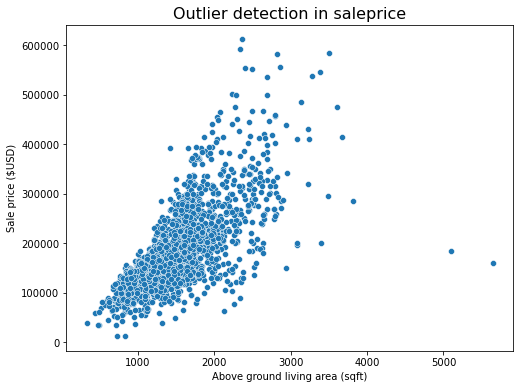

In [34]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='gr_liv_area',y='saleprice',data=ames);
plt.xlabel('Above ground living area (sqft)')
plt.ylabel('Sale price ($USD)')
plt.title('Outlier detection in saleprice', size=16);

In [35]:
ames=ames[ames['gr_liv_area']<4000]

### Identify binary vars and reformat as such
'Central air' just has Y and N entries.  Change to 1,0 (essentially same as dummifying + drop_first).  
'Paved drive' has Yes, No, and Partial entries.  To binarize, will include Partial into Yes.  
'Masonry veneer type' is awfully specific.  Let's reduce to has (1) or has not (0) veneer.

In [36]:
ames['central_air'] = ames['central_air'].map({'Y':1, 'N':0})
ames['paved_drive'] = ames['paved_drive'].map({'Y':1, 'P':1, 'N':0})
ames['mas_vnr_type'] = ames['mas_vnr_type'].map({'BrkFace':1, 'Stone':1, 'BrkCmn':1,
                                                'CBlock':1, 'None':0})

## Copy cleaned df at this point for reference
df reference for cleaned nulls but no further transformations (no drops, no log transformation, no dummies).

In [37]:
training_basic_clean = ames.copy()

## Log transform target: Saleprice
This makes the features more normal, ala the before and after histograms below.  "Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally. (source 3)."  Still working on fully synthesizing this, but the graphs below are evidence enough.  Log transformation should be used on highly skewed distributions to make outliers less influential, and make patterns more interpretable.

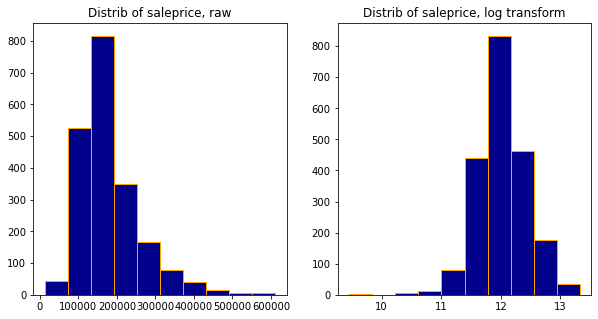

In [38]:
plt.figure(figsize=(10,5))
ax1 = plt.subplot(1,2,1)
ax1.set_title('Distrib of saleprice, raw')
ax1.hist(ames['saleprice'], color = 'darkblue', ec='orange')

ax2 = plt.subplot(1,2,2)
ax2.set_title('Distrib of saleprice, log transform')
ax2.hist(np.log1p(ames['saleprice']),color='darkblue', ec='orange');

In [39]:
ames['saleprice'] = np.log1p(ames['saleprice'])
y = ames['saleprice']

## Correlation
Now that things are clean(er), let's look at correlation of numeric vars. Heatmap is overwhelming because overloaded with variables, but can pick out heaviest hitters for saleprice.

My first approach would be to select the most strongly correlated variables, and pare them down further by trying to eliminate collinearity (ie garage sqft and garage car capacity are collinear, drop one, or combine). Looking ahead it seems like Lasso and Ridge approaches specifically address multicollinearity and parsimony, likely with much better results than I will get by thinking about real estate.

For now, move forward with rudimentary MLR. Then incorporate techniques from the more instructuve kernels and upcoming lecture and see what changes.

In [40]:
#way too busy
# plt.figure(figsize=(16,12))
# mask=np.zeros_like(ames_log_nums.corr())
# mask[np.triu_indices_from(mask)] = True
# sns.heatmap(ames_log_nums.corr(),cmap='coolwarm', annot=False,mask=mask, vmin=-1, vmax=1);

In [41]:
ames.corr()[['saleprice']].sort_values('saleprice', ascending=False).head(15)

,saleprice
saleprice,1.000000
overall_qual,0.825608
gr_liv_area,0.708457
exter_qual,0.692655
kitchen_qual,0.683071
garage_cars,0.667440
total_bsmt_sf,0.655644
garage_area,0.654759
bsmt_qual,0.642841
1st_flr_sf,0.626130


## Proceed to drop everything you've earmarked so far.
##### Due to nulls: 'Lot Frontage', 'Garage Yr Built'.
---
##### Due to low info: 'Alley', 'Misc Features', 'Fence', 'Pool QC', and 'Pool Area' (by association with Pool QC)
---
##### Irrelevant:  'PID' because not helpful for prediction process.  Deleted 'ID' too initially but turns out need that for submission...
---
##### After transforming Y and looking at corr, return to drop more vars for various reasons:
* Masonry Veneer Area: already have type, area insignificant
* Basement Finish Type 2: excessive basement metrics, ultimate sqft and qual matter
* Basement sqft  2: excessive basement metrics
* Basement Unfinished sqft:excessive basement metrics
* Fireplaces: 'Fireplace Qual' has 0 for no fireplace, so is both a semi-count and rank
* Garage Car Capacity: collinear with garage sqft
* Garage Condition: collinear with garage quality
* 3-Season Porch: excessive porch descriptors
* Screen Porch: excessive porch descriptors
* Miscellaneous Value: this is the value of the Misc Features column, already dropped and 97% empty
* Overall Cond: same vibe as Overall Qual, no strong correlation with saleprice.
*     * EDIT: actually preserve Overall Cond in case want to combine with Qual for total score later.
---
In basic cleaning, random NaNs consistently corresponded with "values that could reasonably be assumed to be None/0".  This reassures us that we can treat the Test data identically without having to investigate every spare null.  

Alley, Pool/Pool QC, Misc Feature/Misc Val were dropped due to their high instance of nulls (>90%).  Maybe revisit this criterion again later to cull more.

In [42]:
#investigating few vars in question from the null scrubbing
questionables = ames[['fence','pool_qc','pool_area','saleprice']]

In [43]:
questionables.corr()  #nothing compelling

,fence,pool_qc,pool_area,saleprice
fence,1.000000,0.129047,0.152469,-0.143628
pool_qc,0.129047,1.000000,0.898498,0.037976
pool_area,0.152469,0.898498,1.000000,0.031887
saleprice,-0.143628,0.037976,0.031887,1.000000


In [44]:
cols_to_drop=['pid','alley','misc_feature','misc_val','garage_yr_blt','lot_frontage',
              'fence', 'pool_qc','pool_area','mas_vnr_area','bsmtfin_type_2','bsmt_unf_sf',
              'fireplaces','garage_cars','garage_cond','3ssn_porch','screen_porch']

In [45]:
ames.drop(columns=cols_to_drop,inplace=True)

In [46]:
ames.shape

(2049, 64)

## Transform skewed numeric values
##### This whole section following steps from sources 3 and 4.
---
### Just like for [saleprice], transform all numerical vars with skew>0.5
---

In [47]:
#isolate numerical vs categorical vars
numerical = ames.select_dtypes(exclude = ["object"]).columns #len=44, drop target (saleprice)
#want X param separated for model input
categorical = ames.select_dtypes(include = ["object"]).columns  #len=19

ames_nums= ames[numerical].drop(columns='saleprice')
ames_cats= ames[categorical]

In [48]:
#find skewed numeric features.  Code from source 3, and 4
#"general rule of thumb, abv(skew)>.5 is 'moderately skewed'" - source 3
allskew = ames_nums.apply(lambda x: skew(x))
sigskew = allskew[abs(allskew)>0.5]  #len=38 vars for transformation

In [49]:
sigskew_features = sigskew.index #source 3
ames_nums[sigskew_features] = np.log1p(ames_nums[sigskew_features])

## Next step: Dummify categorical vars
I thought I might be picking the important ones through some research or instinct and going from there, but kaggle practice seems to be DUMMIFY EVERYTHING.  I'm for it.  Let's go.

In [50]:
#ames_cats.isnull().sum()  #double check no nulls.
ames_cats = pd.get_dummies(ames_cats, drop_first=True)

In [51]:
#merge log'd nums with dummified cats
#now have complete training set MINUS target=saleprice
train_log_dum = pd.concat([ames_nums, ames_cats, ames['saleprice']], axis=1)

### df checkpoint for reference:
train_log_dum = the training dataset with all of the var reclassifications, drops, null reassignments, log transformations of skewed numericals, and dummification of all categoricals.  Includes log transformed saleprice.

In [52]:
#backup in case you irreparably damage things in testing and don't want to start over
train_log_dum_backup = train_log_dum.copy()

# Basic LR
These first models do NOT account for collinearity.  

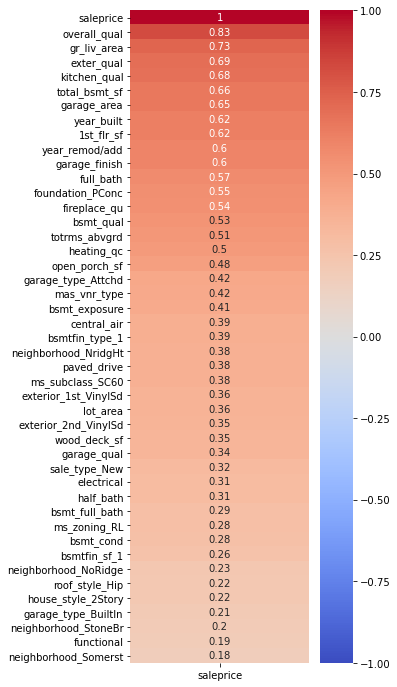

In [53]:
plt.figure(figsize=(4,12))
sp_corr= train_log_dum.corr()[['saleprice']].sort_values('saleprice', ascending=False).head(45)
sns.heatmap(sp_corr, cmap = 'coolwarm', annot=True, vmin=-1, vmax=1);

### Workflow:
* Create features matrix (X), and target vector (y)
* Train, test, split
* Instantiate model
* Cross validate
* Fit and Score

In [54]:
#heatmap by top 10 vars
train_corr = train_log_dum.corr()
#index top 11 features, since target included (to get top 10 impact features)
n = 11
cols_top10 = train_log_dum.corr().nlargest(n, 'saleprice')['saleprice'].index

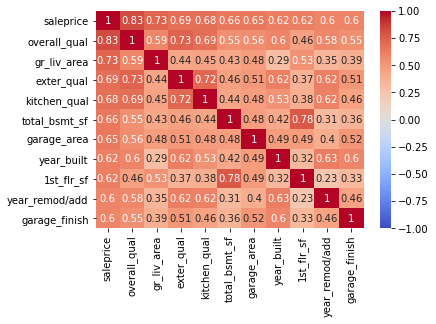

In [55]:
#whoa THIS only restrics horizontal to the selected features, and all features on vert.
  #sns.heatmap(train_corr[cols_corrs_top10], annot = True, vmin = -1, vmax = 1, cmap = 'coolwarm');
#code from source 2 to get square:
cm = np.corrcoef(train_log_dum[cols_top10].values.T)
sns.heatmap(cm,cbar=True, annot=True, vmin=-1, vmax=1, cmap='coolwarm',#axes are labeled 1-10 unless specify
           xticklabels=cols_top10.values, yticklabels = cols_top10.values);

### X = all vars with corr > 0.3

In [56]:
#general filter by correlation >= .3
# does NOT account for collinearity
# considered applying standardscalar but "not needed for regular LR"
#index all features over .3 correlation, drop target
cols_corrs_over3 = train_corr['saleprice'].sort_values(ascending = False).loc[train_corr['saleprice']>.3].drop('saleprice').index

y = train_log_dum['saleprice']
X = train_log_dum[cols_corrs_over3]

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [58]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [59]:
#regular cross_val_score returns r2.
#define function to return rmse
def rmse_train_test(model,split):
    rmse_train = -cross_val_score(model, X_train, y_train, scoring="neg_root_mean_squared_error", cv=split).mean()
    rmse_test = -cross_val_score(model, X_test, y_test, scoring='neg_root_mean_squared_error',cv=split).mean()
    return rmse_train, rmse_test
# 'neg' mse bc default scoring operates under higher is better.  'neg' reverses this.
# then (-) cancels it out...

In [60]:
rmse_train_test(lr,5)

(0.1333963286589547, 0.15464741013556324)

In [61]:
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)
resids_train = y_train - y_pred_train
resids_test = y_test - y_pred_test
resids_baseline = y_test - np.mean(y_train)

##### Visualizations guided by source 2

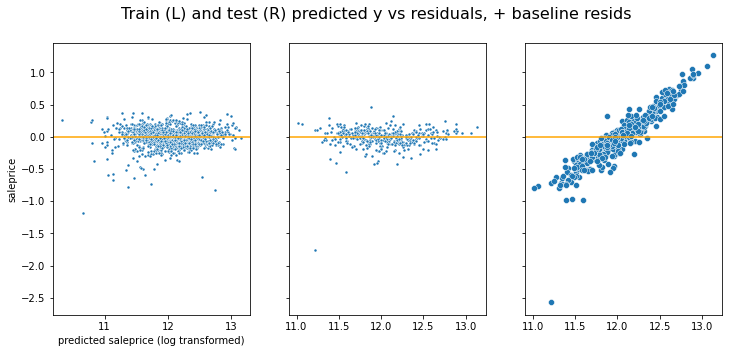

In [62]:
#plot residuals
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,5),sharey=True)
sns.scatterplot(x=y_pred_train, y=resids_train, marker = '.', ax=ax1)
ax1.axhline(0, color='orange')
sns.scatterplot(x=y_pred_test, y=resids_test, marker='.', ax = ax2)
ax2.axhline(0, color='orange');
sns.scatterplot(x=y_pred_test, y=resids_baseline)
ax3.axhline(0, color = 'orange')
ax1.set_xlabel('predicted saleprice (log transformed)')
plt.suptitle('Train (L) and test (R) predicted y vs residuals, + baseline resids',size = 16);


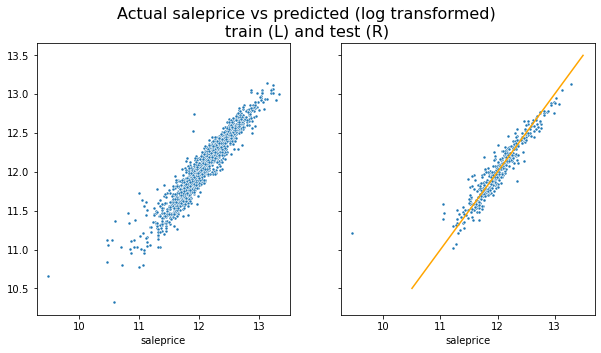

In [63]:
#plot predictions
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5),sharey=True)
sns.scatterplot(x=y_train, y=y_pred_train, marker = '.', ax=ax1)
sns.scatterplot(x=y_test, y=y_pred_test, marker='.', ax = ax2);
plt.plot([10.5, 13.5], [10.5, 13.5], color = 'orange'); #how do I get this on both plots??!
plt.suptitle('Actual saleprice vs predicted (log transformed)\ntrain (L) and test (R)',size = 16);

### X = top 10 corr vars
RMSE higher than (corr > .3) model

In [64]:
features_10= cols_top10.drop('saleprice')
X = train_log_dum[features_10]
y= train_log_dum['saleprice']

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2, random_state=42)

In [66]:
rmse_train_test(lr,5)

(0.15324359800372617, 0.1683165175879325)

### X = corr > .2

In [67]:
cols_corrs_over2 = train_corr['saleprice'].sort_values(ascending = False).loc[train_corr['saleprice']>.2].drop('saleprice').index


In [68]:
ames.mas_vnr_type.value_counts()

0    1240
1     809
Name: mas_vnr_type, dtype: int64

In [69]:
train_log_dum.saleprice.mean()

12.024376151206718

In [70]:
np.expm1(train_log_dum.saleprice.mean())

166769.876310459

In [71]:
test_set.dtypes

Id                   int64
PID                  int64
MS SubClass          int64
MS Zoning           object
Lot Frontage       float64
Lot Area             int64
Street              object
Alley               object
Lot Shape           object
Land Contour        object
Utilities           object
Lot Config          object
Land Slope          object
Neighborhood        object
Condition 1         object
Condition 2         object
Bldg Type           object
House Style         object
Overall Qual         int64
Overall Cond         int64
Year Built           int64
Year Remod/Add       int64
Roof Style          object
Roof Matl           object
Exterior 1st        object
Exterior 2nd        object
Mas Vnr Type        object
Mas Vnr Area       float64
Exter Qual          object
Exter Cond          object
Foundation          object
Bsmt Qual           object
Bsmt Cond           object
Bsmt Exposure       object
BsmtFin Type 1      object
BsmtFin SF 1         int64
BsmtFin Type 2      object
B